In [1]:
# Let's import all packages that we may need:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import os
import xgboost as xgb


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
import geohash2 as geohash



Using TensorFlow backend.


### Prepossesing Data

In [ ]:
# df = pd.read_csv('/Users/Celia/Desktop/Traffic Management/training.csv')

# df[["lat","lon"]] = df["geohash"].apply(lambda x: pd.Series(
#      {"lat":geohash.decode_exactly(x)[0],
#       "long": geohash.decode_exactly(x)[1]}))
# new_training = df.to_csv('/Users/Celia/Desktop/Traffic Management/new_training.csv')

Decode the goehash form raw dataset to get latitude and longtitude at first and save it to another file for the purpose of saving computer memory. ↑

In [44]:
df = pd.read_csv('/Users/Celia/Desktop/Traffic Management/new_training.csv',index_col=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [45]:
df.head()

,geohash6,day,timestamp,demand,lat,lon
0,qp03wc,18,20:0,0.020072,-5.353088,90.653687
1,qp03pn,10,14:30,0.024721,-5.413513,90.664673
2,qp09sw,9,6:15,0.102821,-5.325623,90.906372
3,qp0991,32,5:0,0.088755,-5.353088,90.752563
4,qp090q,15,4:0,0.074468,-5.413513,90.719604


In [46]:
#Creating some new features
df[['h','m']] = df['timestamp'].astype(str).str.split(':', expand=True).astype(int)

#timebin
df["timebin_no"] = ((df["h"]*60+df["m"]) / 15).astype(int)

#day
df['map_day'] = df['day']%7

df.head()

,geohash6,day,timestamp,demand,lat,lon,h,m,timebin_no,map_day
0,qp03wc,18,20:0,0.020072,-5.353088,90.653687,20,0,80,4
1,qp03pn,10,14:30,0.024721,-5.413513,90.664673,14,30,58,3
2,qp09sw,9,6:15,0.102821,-5.325623,90.906372,6,15,25,2
3,qp0991,32,5:0,0.088755,-5.353088,90.752563,5,0,20,4
4,qp090q,15,4:0,0.074468,-5.413513,90.719604,4,0,16,1


**Origin dataset**
<li><b>Geohash6 :</b> Geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision</li>
<li><b>Timestamp:</b>
start time of 15-minute intervals, in the following format: (hour:minute), where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45) </li>
<li><b>Day :</b>day, where the value indicates the sequential order and not a particular day of the month</li>
<li><b>Demand :</b> aggregated demand normalised to be in the range [0,1]</li>

<br>
**Note that we create two new features**
<li><b>timebin_no : </b> Transfer the whole time into 15-min time bin ex: 24*4 = 96 bins</li>
<li><b>map_day :</b> We retrieve the remainder of day column when it is divided by 7</li>

In [4]:
train = df[['geohash6', 'timebin_no', 'map_day','demand']]

In [5]:
train.head()

,geohash6,timebin_no,map_day,demand
0,qp03wc,80,4,0.020072
1,qp03pn,58,3,0.024721
2,qp09sw,25,2,0.102821
3,qp0991,20,4,0.088755
4,qp090q,16,1,0.074468


In [6]:
train["uid"] =train["geohash6"].astype(str)+ "_"+train["timebin_no"].astype(str)+"_"+ train["map_day"].astype(str)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We aggregate the number of taxi demands during every time-step length.That is to say, we group by the raw taxi data by each time bin, Geohash code and the map_day. In such a way, historical taxi data in each area becomes the aggregated number of demand data sequences.We get an observation that there are some time_bins that do not have any demand so we fill a value of zero for every bins where no demand data is present.

In [7]:
train.head()

,geohash6,timebin_no,map_day,demand,uid
0,qp03wc,80,4,0.020072,qp03wc_80_4
1,qp03pn,58,3,0.024721,qp03pn_58_3
2,qp09sw,25,2,0.102821,qp09sw_25_2
3,qp0991,20,4,0.088755,qp0991_20_4
4,qp090q,16,1,0.074468,qp090q_16_1


In [8]:
all_locs = train['geohash6'].unique()

In [9]:
all_bins = train['timebin_no'].unique()

In [10]:
all_day = train['map_day'].unique()

In [11]:
print(len(all_locs))
print(len(all_bins))
print(len(all_day))

1329
96
7


In [12]:
df_groupbyall = train.groupby(['uid']).demand.agg({'demand':'sum'})   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [13]:
1329*96*7

893088

893088 is the number of columns we need to have

In [14]:
uid_demand = df_groupbyall.reset_index()
existing_uids = uid_demand.uid.tolist()

In [15]:
all_uid = []
for loc in all_locs:
    for b in all_bins:
        for d in all_day:
            uid = "{}_{}_{}".format(loc,b,d)
            all_uid.append([uid,0])         

In [16]:
all_uid_demand = pd.DataFrame(all_uid, columns =['uid','demand'])

In [17]:
result = pd.merge(uid_demand,all_uid_demand,  on=['uid'], how="outer")

In [18]:
result['demand'] = result['demand_x']
result['demand'].fillna(0, inplace=True)

In [19]:
result = result[['uid', 'demand']]

In [20]:
split_out =  result["uid"].str.split("_", n = 2, expand = True) 

In [21]:
result['geohash'] = split_out[0]
result['timebin'] = split_out[1].astype(int)
result['day'] = split_out[2].astype(int)

In [22]:
result = result.drop(['uid'],axis=1)

In [23]:
result.head()

,demand,geohash,timebin,day
0,0.007733,qp02yc,0,0
1,0.010381,qp02yc,0,1
2,0.027875,qp02yc,0,2
3,0.084679,qp02yc,0,3
4,0.010563,qp02yc,0,6


In [24]:
# result[["lat","lon"]] = result["geohash"].apply(lambda x: pd.Series(
#      {"lat":geohash.decode_exactly(x)[0],
#       "long": geohash.decode_exactly(x)[1]}))

Sorting the dataframe by timebin and day

In [25]:
result = result.sort_values(by=['geohash', 'timebin','day']).reset_index()

In [26]:
result = result.drop(['index'],axis=1)

In [27]:
result.head()

,demand,geohash,timebin,day,lat,lon
0,0.007733,qp02yc,0,0,-5.484924,90.653687
1,0.010381,qp02yc,0,1,-5.484924,90.653687
2,0.027875,qp02yc,0,2,-5.484924,90.653687
3,0.084679,qp02yc,0,3,-5.484924,90.653687
4,0.000000,qp02yc,0,4,-5.484924,90.653687


In [3]:
#result = result.to_csv('/Users/Celia/Desktop/Traffic Management/result.csv')

In [2]:
result = pd.read_csv('/Users/Celia/Desktop/Traffic Management/result.csv',index_col=0)

In [5]:
unique_geohash = result.geohash.unique().tolist()
result['geohash_n'] = result.geohash.apply(lambda x: unique_geohash.index(x))


In [78]:
result.head()

,demand,geohash,timebin,day,lat,lon
0,0.007733,qp02yc,0,0,-5.484924,90.653687
1,0.010381,qp02yc,0,1,-5.484924,90.653687
2,0.027875,qp02yc,0,2,-5.484924,90.653687
3,0.084679,qp02yc,0,3,-5.484924,90.653687
4,0.000000,qp02yc,0,4,-5.484924,90.653687


In [69]:
Y = result["demand"]
X = result.drop(['demand','geohash'], axis=1)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [71]:
#### Randomforest
RFR = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
RFR.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [72]:
RFRtrain_pred = RFR.predict(x_train)
RFRtest_pred = RFR.predict(x_test)

In [73]:
rmse_train = np.sqrt(mean_squared_error(RFRtrain_pred, y_train))
rmse_test = np.sqrt(mean_squared_error(RFRtest_pred, y_test))
print ("RMSE (train) = %0.6f, RMSE (test) = %0.6f" % (rmse_train, rmse_test))

RMSE (train) = 0.084025, RMSE (test) = 0.104904


However, we should notice that this is a time series problem, Random Forests don’t fit very well for increasing or decreasing trends which are usually encountered when dealing with time-series analysis, such as seasonality! An idea to further improve predictions using Random Forests is to flatten the data.

### Preparing time series format for training

<p>A time series must be transformed into samples with input and output components. The transform both informs what the model will learn and how you intend to use the model in the future when making predictions, e.g. what is required to make a prediction (X) and what prediction is made (y).</p>

#### Creating input features corresponding to the amount of taxi demand in the last five 15-min bins

In [3]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [4]:
df_sequence = np.asarray(list(range(96)))

In [5]:
X, y = split_sequence(df_sequence, 5)
print(X.shape, y.shape)
# # show each sample
for i in range(len(X)):
      print(X[i], y[i])

(91, 5) (91,)
[0 1 2 3 4] 5
[1 2 3 4 5] 6
[2 3 4 5 6] 7
[3 4 5 6 7] 8
[4 5 6 7 8] 9
[5 6 7 8 9] 10
[ 6  7  8  9 10] 11
[ 7  8  9 10 11] 12
[ 8  9 10 11 12] 13
[ 9 10 11 12 13] 14
[10 11 12 13 14] 15
[11 12 13 14 15] 16
[12 13 14 15 16] 17
[13 14 15 16 17] 18
[14 15 16 17 18] 19
[15 16 17 18 19] 20
[16 17 18 19 20] 21
[17 18 19 20 21] 22
[18 19 20 21 22] 23
[19 20 21 22 23] 24
[20 21 22 23 24] 25
[21 22 23 24 25] 26
[22 23 24 25 26] 27
[23 24 25 26 27] 28
[24 25 26 27 28] 29
[25 26 27 28 29] 30
[26 27 28 29 30] 31
[27 28 29 30 31] 32
[28 29 30 31 32] 33
[29 30 31 32 33] 34
[30 31 32 33 34] 35
[31 32 33 34 35] 36
[32 33 34 35 36] 37
[33 34 35 36 37] 38
[34 35 36 37 38] 39
[35 36 37 38 39] 40
[36 37 38 39 40] 41
[37 38 39 40 41] 42
[38 39 40 41 42] 43
[39 40 41 42 43] 44
[40 41 42 43 44] 45
[41 42 43 44 45] 46
[42 43 44 45 46] 47
[43 44 45 46 47] 48
[44 45 46 47 48] 49
[45 46 47 48 49] 50
[46 47 48 49 50] 51
[47 48 49 50 51] 52
[48 49 50 51 52] 53
[49 50 51 52 53] 54
[50 51 52 53 54] 55
[

Above is the new format we like to have

In [6]:
def to_supervised(data, X):
    totallist= []
    for j in range (5):
        regions = []
        for geo in range(1329):
            valuelist = []
            for i in range (91):
                index = X[i][j]
                index = index + geo*96
                num_list = data[index*7:(index+1)*7]
                valuelist.extend(num_list)

            regions.append(valuelist)   
        totallist.append(regions)
    return totallist

In [7]:
X_inputs = to_supervised(result.demand.values, X)

In [8]:
print(len(X_inputs),len(X_inputs[0]),len(X_inputs[0][0]))

5 1329 637


#### Creating the output variable (yi)

In [9]:
def to_supervised(data, y):
    totallist= []
    regions = []
    for geo in range(1329):
        valuelist = []
        for i in range (91):
            index = y[i]
            index = index + geo*96
            num_list = data[index*7:(index+1)*7]
            valuelist.extend(num_list)

        regions.append(valuelist)   
    totallist.append(regions)
    return totallist 

In [10]:
output = to_supervised(result.demand.values, y)

In [11]:
print(len(output),len(output[0]),len(output[0][0]))

1 1329 637


#### Train test split

In [12]:
print("size of train data :", int(91*0.8))      # First 70%
print("size of test data :", 91-int(91*0.8))  # Last 30%

size of train data : 72
size of test data : 19


This means that, **from every geohash** the first 72 data points will go to the training set and the last 19 points will go to the test set.

Thus:
* Total no. of points in training set = 72\*1329\*7 = 669816
* Total no. of points in test set = 19\*1329\*7 = 176757

**Note**
<p>In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it.However,these methods cannot be directly used with time series data.This is because they assume that there is no relationship between the observations, that each observation is independent.This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed.</p>

In [13]:
def timeseries_train_test_split_for_inputs(X, train_size):
    """
        Perform train-test split with respect to time series structure
    """
    
        # get the index after which test set starts
    Xtrain_features = []
    Xtest_features = []
    for i in range (5):
        train_list = [] 
        test_list = []
        for num in range (1329):
            trains = X[i][num][:train_size*7]
            tests = X[i][num][train_size*7:]
            train_list.extend(trains)
            test_list.extend(tests)
        Xtrain_features.append(train_list)
        Xtest_features.append(test_list)
    
    return Xtrain_features, Xtest_features

In [15]:
Xtrain_features, Xtest_features = timeseries_train_test_split_for_inputs(X_inputs, 72)

In [16]:
print(len(Xtrain_features[0]),len(Xtest_features[0]))

669816 176757


In [17]:
def timeseries_train_test_split_for_outputs(y, train_size):
    """
        Perform train-test split with respect to time series structure
    """
    ytrain_features = []
    ytest_features = []
    for i in range (1329):
        ytrain_features.extend(y[0][i][:train_size*7])
        ytest_features.extend(y[0][i][train_size*7:])
    return ytrain_features , ytest_features

In [18]:
ytrain_features, ytest_features = timeseries_train_test_split_for_outputs(output,72)

In [19]:
print(len(ytrain_features),len(ytest_features))

669816 176757


#### Creating latitude and Longitude  and day features

In [20]:
latitude = result.lat.values
longitude = result.lon.values
day = result.day.values

In [21]:
train_lats = []
test_lats = []
train_lons = []
test_lons = []
for num in range (1329):
    index = num*96*7
    train_lats += 72*7*[latitude[index]]
    train_lons += 72*7*[longitude[index]]
    test_lats += 19*7*[latitude[index]]
    test_lons += 19*7*[longitude[index]]

In [22]:
print(len(train_lats),len(train_lons),len(test_lats),len(test_lons))

669816 669816 176757 176757


In [23]:
train_days = []
train_days += 72*1329*[list(set(day))]
train_days = sum(train_days, [])
test_days = []
test_days += 19*1329*[list(set(day))]
test_days = sum(test_days, [])

In [24]:
print(len(train_days),len(test_days))

669816 176757


In [25]:
# prepare for  train dataframe
X_train = pd.DataFrame()
X_train['ft_5'] = Xtrain_features [0]
X_train['ft_4'] = Xtrain_features [1]
X_train['ft_3'] = Xtrain_features [2]
X_train['ft_2'] = Xtrain_features [3]
X_train['ft_1'] = Xtrain_features [4]
X_train['lat'] = train_lats
X_train['lon'] = train_lons
X_train['day'] = train_days

In [26]:
# prepare for test dataframe
X_test = pd.DataFrame()
X_test['ft_5'] = Xtest_features [0]
X_test['ft_4'] = Xtest_features [1]
X_test['ft_3'] = Xtest_features [2]
X_test['ft_2'] = Xtest_features [3]
X_test['ft_1'] = Xtest_features [4]
X_test['lat'] = test_lats
X_test['lon'] = test_lons
X_test['day'] = test_days

In [27]:
X_train.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,day
0,0.007733,0.000000,0.0,0.000000,0.000190,-5.484924,90.653687,0
1,0.010381,0.000000,0.0,0.000000,0.000000,-5.484924,90.653687,1
2,0.027875,0.000000,0.0,0.000000,0.000000,-5.484924,90.653687,2
3,0.084679,0.013571,0.0,0.015341,0.090787,-5.484924,90.653687,3
4,0.000000,0.000000,0.0,0.000000,0.010794,-5.484924,90.653687,4


In [28]:
X_train, X_test, y_train, y_test = X_train, X_test, ytrain_features, ytest_features

### Modeling

#### Randomforest

In [101]:
#### Randomforest
RFR = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
RFR.fit(X_train, y_train)

RFRtrain_pred = RFR.predict(X_train)
RFRtest_pred = RFR.predict(X_test)

In [102]:
rmse_train = np.sqrt(mean_squared_error(RFRtrain_pred, y_train))
rmse_test = np.sqrt(mean_squared_error(RFRtest_pred, y_test))
print (" RMSE (train) = %0.6f, RMSE (test) = %0.6f" % (rmse_train, rmse_test))

 RMSE (train) = 0.070520, RMSE (test) = 0.091750


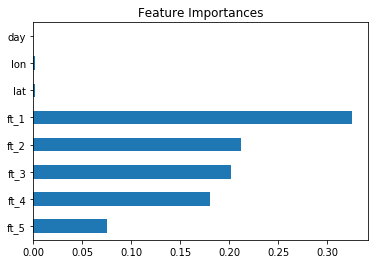

In [107]:
## future importance
plt.title('Feature Importances')
feat_importances = pd.Series(RFR.feature_importances_, index = X_train.columns)
feat_importances.plot(kind='barh')

#### Xgboost

In [103]:
#### Xgboost

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=500, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=200,
       reg_lambda=200, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [104]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

train_pred = x_model.predict(X_train)
test_pred = x_model.predict(X_test)

In [105]:
rmse_train = np.sqrt(mean_squared_error(train_pred, y_train))
rmse_test = np.sqrt(mean_squared_error(test_pred, y_test))
print ("RMSE (train) = %0.6f, RMSE (test) = %0.6f" % (rmse_train, rmse_test))

RMSE (train) = 0.102508, RMSE (test) = 0.088560


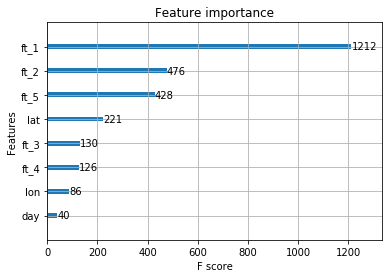

In [106]:
## future importance
xgb.plot_importance(x_model, importance_type = 'weight')

#### LSTM model

In [29]:
XLSTM_train = X_train.drop(['lat','lon','day'],axis=1)
XLSTM_test = X_test.drop(['lat','lon','day'],axis=1)

In [30]:
XLSTM_train = XLSTM_train.values
XLSTM_test = XLSTM_test.values

In [31]:
X_train, X_test, y_train, y_test = XLSTM_train, XLSTM_test, ytrain_features, ytest_features

In [32]:
print(X_train.shape,len(y_train))

(669816, 5) 669816


In [33]:
print(X_test.shape,len(y_test))

(176757, 5) 176757


In [34]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [35]:
print(X_train.shape,X_test.shape)

(669816, 5, 1) (176757, 5, 1)


In [36]:
# define model
n_steps = 5
n_features = 1

model = Sequential()
model.add(LSTM(24, input_shape=(n_steps, n_features))) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [37]:
# fit model
history = model.fit(X_train, y_train, epochs=80, batch_size=100,
                    validation_data=(X_test, y_test), verbose=2, shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 669816 samples, validate on 176757 samples
Epoch 1/80
 - 51s - loss: 0.0505 - val_loss: 0.0080
Epoch 2/80
 - 49s - loss: 0.0128 - val_loss: 0.0071
Epoch 3/80
 - 47s - loss: 0.0117 - val_loss: 0.0071
Epoch 4/80
 - 47s - loss: 0.0115 - val_loss: 0.0071
Epoch 5/80
 - 47s - loss: 0.0113 - val_loss: 0.0070
Epoch 6/80
 - 48s - loss: 0.0110 - val_loss: 0.0071
Epoch 7/80
 - 1997s - loss: 0.0110 - val_loss: 0.0070
Epoch 8/80
 - 48s - loss: 0.0109 - val_loss: 0.0072
Epoch 9/80
 - 48s - loss: 0.0109 - val_loss: 0.0071
Epoch 10/80
 - 47s - loss: 0.0108 - val_loss: 0.0072
Epoch 11/80
 - 48s - loss: 0.0109 - val_loss: 0.0072
Epoch 12/80
 - 48s - loss: 0.0108 - val_loss: 0.0070
Epoch 13/80
 - 51s - loss: 0.0107 - val_loss: 0.0069
Epoch 14/80
 - 49s - loss: 0.0106 - val_loss: 0.0071
Epoch 15/80
 - 50s - loss: 0.0107 - val_loss: 0.0072
Epoch 16/80
 - 50s - loss: 0.0107 - val_loss: 0.0072
Epoch 17/80
 - 49s - loss: 0.0107 - val_loss: 0.0072
Epoch 

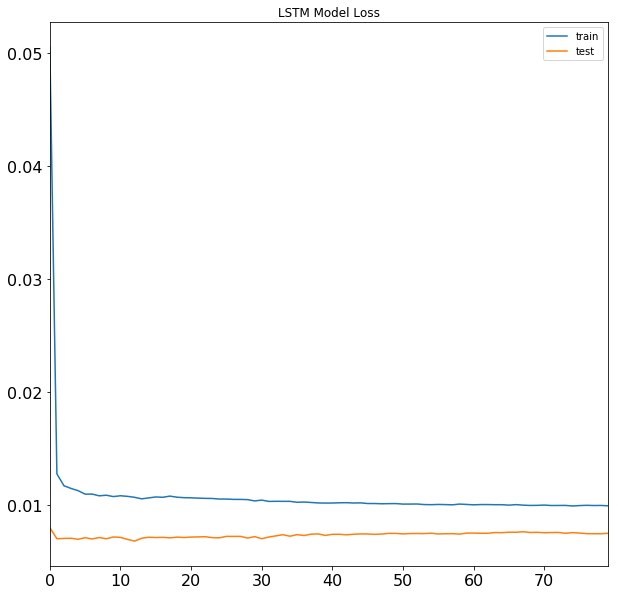

In [38]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss')

In [39]:
# make a prediction
yhat = model.predict(X_test)

In [40]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.6f' % rmse)

Test RMSE: 0.086824
